In [ ]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append(f'{ROOT_DIR}/code/helper/')
sys.path.append(f'{ROOT_DIR}/code/Synthetic/')
import OTCost as ot
import KL as kl
import dataCreator as dc
import importlib
import random
from sklearn.utils import shuffle
importlib.reload(ot)
importlib.reload(kl)
importlib.reload(dc)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.special import kl_div

## synthetic

In [2]:
def loadData(name):
    ##load data
    X = pd.read_csv(f'{ROOT_DIR}/data/Synthetic/{name}.csv', sep = ' ', names = [i for i in range(13)])
    
    ##shuffle
    X = X.sample(frac = 1)
    return X.iloc[:,:-1]

In [6]:
costs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
for c in costs:
    name1, name2 = f'data_1_{c}',f'data_2_{c}'
    d1, d2 = loadData(name1), loadData(name2)
    print(kl.KLdivergence(d1, d2))

0.3257481366449104
0.7494640222967414
1.571490531991267
2.2325600110138426
3.7813330118552937
14.820490916355368
4.622635657589123
0.2398356356006185
0.27033613749384644


## credit

In [7]:
def loadData(name):
    ##load data
    X = pd.read_csv(f'{ROOT_DIR}/data/Credit/{name}.csv', sep = ' ', names = [i for i in range(29)])
    ## shuffle
    X = X.sample(frac = 1)
    ##get X and label
    y = X.iloc[:,-1]
    X = X.iloc[:,:-1]
    return X

In [8]:
costs = [0.1, 0.2, 0.3, 0.4]
for c in costs:
    name1, name2 = f'data_1_{c}',f'data_2_{c}'
    d1, d2 = loadData(name1), loadData(name2)
    print(kl.KLdivergence(d1, d2))

0.885057105994966
22.53975085126525
63.67368710334389
75.54392659350907


## EMNIST

In [9]:
from emnist import extract_training_samples
images_full, labels_full = extract_training_samples('byclass')

In [10]:
def pull_labels(images, labels, indices, size):
    ##get indices for x, i
    indices_x =  getIndices(indices[0], size)
    indices_i =  getIndices(indices[1], size)


    ##randomly permute and take fixed size of points
    #np.random.seed(10)
    indices_x = np.random.permutation(indices_x)
    indices_i = np.random.permutation(indices_i)
    
    ind_1 = indices_x[:size]
    ind_2 = indices_i[:size]

    ##pull data and labels
    X1 = images[ind_1] / 255
    X2 = images[ind_2] / 255
    y1 = labels[ind_1]
    y2 = labels[ind_2]

    ## reshape
    X1 = X1.reshape((size, -1))
    X2 = X2.reshape((size, -1))

    return {"1": X1, "2": X2}, {"1":y1, "2":y2}

In [11]:
def getIndices(indices, size):
    ##get number of indices
    num_ind = len(indices)
    ##get number per label
    num_per_label = int(size / num_ind) + 10
    indices_use = []
    ## loop through and pull indices
    for ind in indices:
        indices_use.extend(np.where(np.isin(labels_full, ind) == True)[0][:num_per_label])
    return indices_use

In [12]:
def sampler(data, label, num = 900):
    data_, label_  = {}, {}
    for i in data:
        idx = np.random.choice(np.arange(data[i].shape[0]), num, replace=False)
        data_[i] = data[i][idx]
        label_[i] = label[i][idx].reshape(1,-1)[0]
    return data_, label_

In [13]:
indices =  [[[12,40], [12, 40]],
            [[33, 30], [33, 56]],
            [[33, 15, 11], [33, 41, 18]],
            [[33, 21, 47, 29, 32], [59, 26, 52, 30, 31]]]
for ind in indices:
    data, label = pull_labels(images_full, labels_full, ind, size = 5000)
    data_, label_ = sampler(data, label, num = 1000)
    print(kl.KLdivergence(data_['1'], data_['2']))


-25.16797905573468
-2.200535772030796
58.152498330046775
275.90060866158063


## exact estimate

In [14]:
##create data
data, label = dc.non_iid_creator2D(1)
## calculate cost
cost = ot.Synthetic_OTCost_label(data, label, private = False)

for i in range(2):
    sns.kdeplot(data['2'][:, i], hue = label['2'])
    plt.title(i)
    plt.show()

cost: 0.8824724127


ValueError: The following variable cannot be assigned with wide-form data: `hue`

In [15]:
def run_test(data, label):
    # train from d2 and test 1
    X_train1, X_test, y_train1, y_test = train_test_split(data['2'],label['2'], test_size = 0.3, random_state=1)
    X_train2, _, y_train2, _ = train_test_split(data['1'],label['1'], test_size = 0.3, random_state=1)

    X_train = np.concatenate((X_train1, X_train2))
    y_train = np.concatenate((y_train1, y_train2))
    
    # run basic LR
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, pred)
    d2 = metrics.auc(fpr, tpr)

    return d1, d2

In [16]:
def kl_calc(data):
    kernel_p =  stats.gaussian_kde(data['1'].T)
    kernel_q =  stats.gaussian_kde(data['2'].T)
    p_x = kernel_p(data['1'].T)
    q_x = kernel_q(data['2'].T)
    return kl_div(p_x, q_x).sum()

In [17]:
def grapher(df, cost, path, save = False):
    sns.lineplot( x= df[cost], y =df['AUC'], alpha = 0.8, marker = 'o', label = f'{cost}')
    plt.xlabel('cost')
    plt.ylabel(f'AUC')
    plt.legend()
    plt.title(f'{cost} cost vs. Test set AUC')
    if save == True:
        plt.savefig(f'{path}{cost}.pdf')
    plt.show()

In [18]:
def saveDataset(data, label, name1, name2):
    d1= np.concatenate((data['1'], label['1'].reshape(-1,1)), axis=1)
    np.savetxt(f'{ROOT_DIR}/data/kl_div/{name1}.csv',d1)

    d2= np.concatenate((data['2'], label['2'].reshape(-1,1)), axis=1)
    np.savetxt(f'{ROOT_DIR}/data/kl_div/{name2}.csv',d2)
    return

In [19]:
fracs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
results = {'OT': [], 'KL': [], "AUC": []}
for i in fracs:
    ##create data
    data, label = dc.non_iid_creator2D(i)
    ## calculate cost
    results['OT'].append(ot.Synthetic_OTCost_label(data, label, private = False))
    results['KL'].append(kl_calc(data))
    _, auc_d2 = run_test(data, label)
    results['AUC'].append(auc_d2)
    saveDataset(data, label, f'd1_{i}', f'd2_{i}')


cost: 0.0039156384
cost: 0.0281199336
cost: 0.1399792552
cost: 0.2012633715
cost: 0.3401497757
cost: 0.4217112737
cost: 0.5215273559
cost: 0.6107357926
cost: 0.6815927147
cost: 0.7900102537
cost: 0.8824724127


In [21]:
df = pd.DataFrame.from_dict(results)
df.to_csv(f'{ROOT_DIR}/results/kl_div/results.csv', index = False)

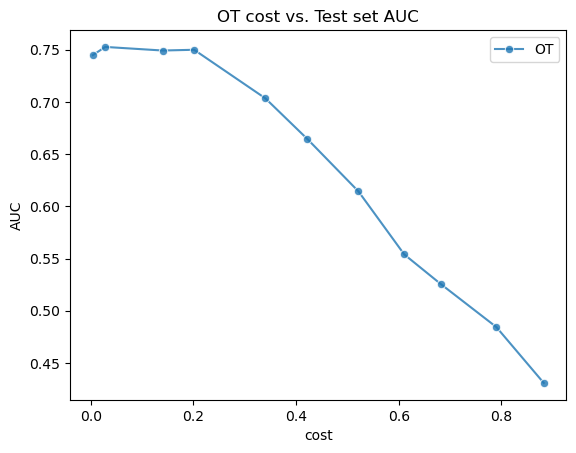

In [24]:
path = f'{ROOT_DIR}/results/kl_div/'
grapher(df, 'OT', path, save = True)

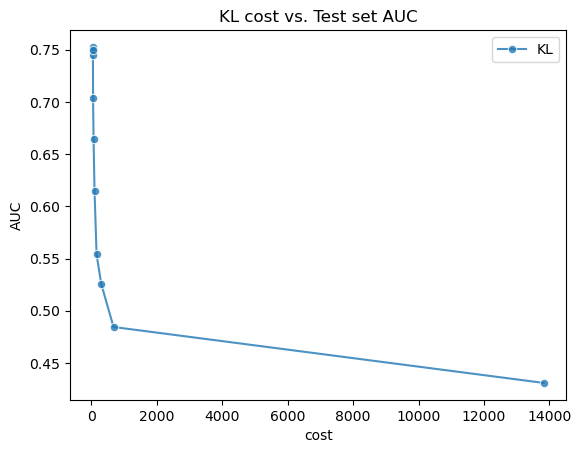

In [25]:
grapher(df, 'KL', path, save = True)